# Random Forest Classifier for Mobile Price Classification Dataset

This notebook implements a Random Forest classifier for the Mobile Price Classification dataset from Kaggle (https://www.kaggle.com/datasets/iabhishekofficial/mobile-price-classification), as required for the VU Machine Learning 2025S assignment. The dataset contains 2000 samples with 20 features (e.g., RAM, battery power, internal memory) and a target variable `price_range` with 4 classes (0: low cost, 1: medium cost, 2: high cost, 3: very high cost). The code follows the lecture steps:
- **Data Import**: Load `train.csv` dataset.
- **Data Exploration**: Check class distribution, missing values, and feature distributions.
- **Preprocessing**: Scale features, split data into training and testing sets.
- **Classification**: Run Random Forest with multiple parameter settings.
- **Evaluation**: Use accuracy, F1-score, ROC-AUC, cross-validation, and runtime metrics.
- **Visualization**: Generate confusion matrix and parameter impact plots.

**Objective**: Classify mobile phones into price ranges based on their features.

## Step 1: Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
import time
import os
%matplotlib inline

## Step 2: Data Exploration

Load the dataset and explore class distribution, missing values, and feature statistics.


Dataset Shape: (2000, 21)

First 5 Rows:
    battery_power  blue  clock_speed  dual_sim  fc  four_g  int_memory  m_dep  \
0            842     0          2.2         0   1       0           7    0.6   
1           1021     1          0.5         1   0       1          53    0.7   
2            563     1          0.5         1   2       1          41    0.9   
3            615     1          2.5         0   0       0          10    0.8   
4           1821     1          1.2         0  13       1          44    0.6   

   mobile_wt  n_cores  ...  px_height  px_width   ram  sc_h  sc_w  talk_time  \
0        188        2  ...         20       756  2549     9     7         19   
1        136        3  ...        905      1988  2631    17     3          7   
2        145        5  ...       1263      1716  2603    11     2          9   
3        131        6  ...       1216      1786  2769    16     8         11   
4        141        2  ...       1208      1212  1411     8     2         15

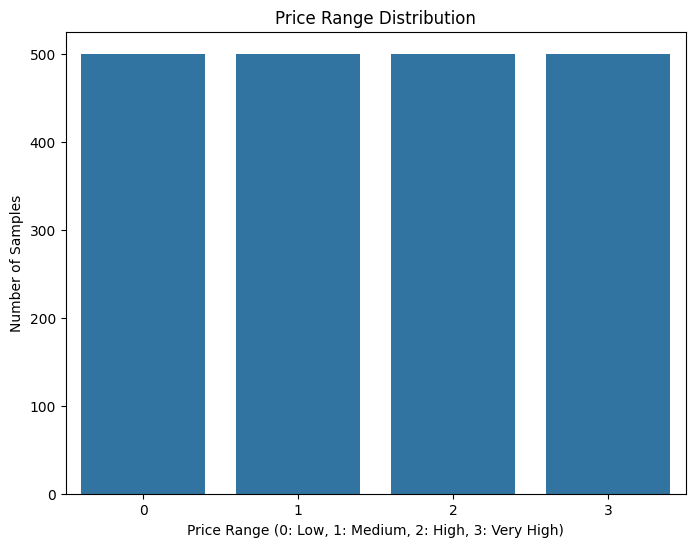


Missing Values:
 Series([], dtype: int64)

Feature Statistics:
        battery_power       blue  clock_speed     dual_sim           fc  \
count    2000.000000  2000.0000  2000.000000  2000.000000  2000.000000   
mean     1238.518500     0.4950     1.522250     0.509500     4.309500   
std       439.418206     0.5001     0.816004     0.500035     4.341444   
min       501.000000     0.0000     0.500000     0.000000     0.000000   
25%       851.750000     0.0000     0.700000     0.000000     1.000000   
50%      1226.000000     0.0000     1.500000     1.000000     3.000000   
75%      1615.250000     1.0000     2.200000     1.000000     7.000000   
max      1998.000000     1.0000     3.000000     1.000000    19.000000   

            four_g   int_memory        m_dep    mobile_wt      n_cores  ...  \
count  2000.000000  2000.000000  2000.000000  2000.000000  2000.000000  ...   
mean      0.521500    32.046500     0.501750   140.249000     4.520500  ...   
std       0.499662    18.145715

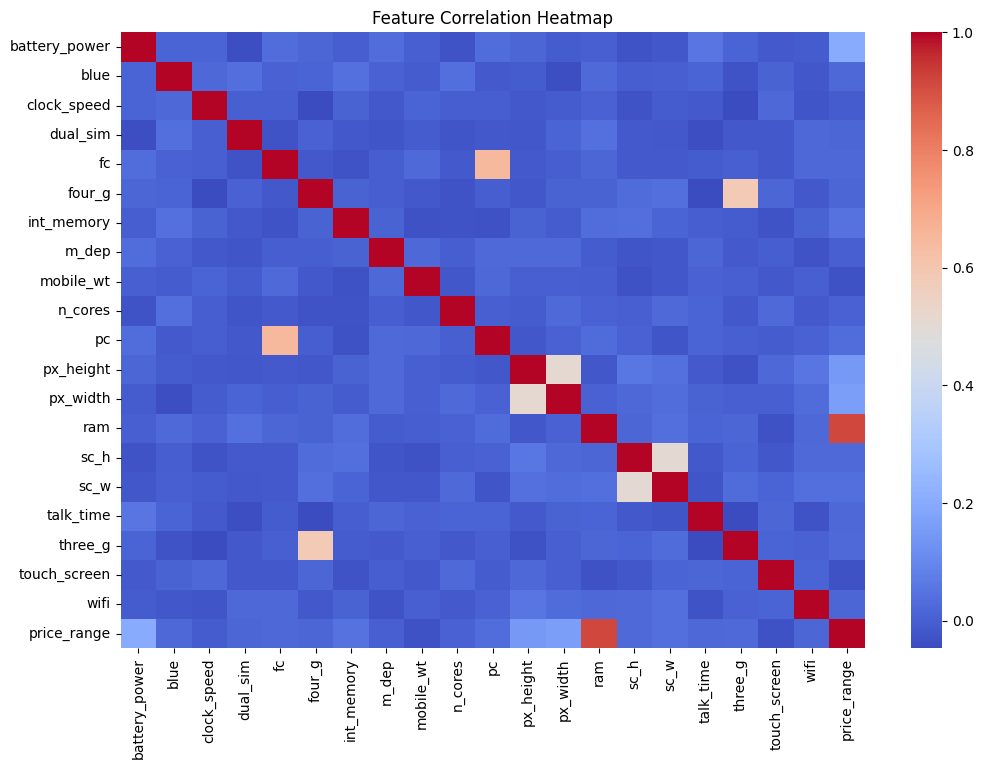

In [2]:
def explore_dataset(df):
    """Explore dataset structure, class distribution, and missing values."""
    print("\nDataset Shape:", df.shape)
    print("\nFirst 5 Rows:\n", df.head())
    print("\nData Types:\n", df.dtypes)
    
    # Class distribution
    class_counts = df['price_range'].value_counts()
    print("\nClass Distribution:\n", class_counts)
    plt.figure(figsize=(8, 6))
    sns.barplot(x=class_counts.index, y=class_counts.values)
    plt.title('Price Range Distribution')
    plt.xlabel('Price Range (0: Low, 1: Medium, 2: High, 3: Very High)')
    plt.ylabel('Number of Samples')
    plt.savefig('class_distribution_mobile.png')
    plt.show()
    
    # Missing values
    missing_values = df.isnull().sum()
    print("\nMissing Values:\n", missing_values[missing_values > 0])
    
    # Feature statistics
    print("\nFeature Statistics:\n", df.describe())
    
    # Feature correlations
    plt.figure(figsize=(12, 8))
    sns.heatmap(df.corr(), cmap='coolwarm', annot=False)
    plt.title('Feature Correlation Heatmap')
    plt.savefig('feature_correlation_mobile.png')
    plt.show()

# Load dataset
data_path = 'train.csv'  # Update with local path to train.csv
df = pd.read_csv(data_path)

# Explore dataset
explore_dataset(df)

## Step 3: Preprocessing

Scale features and split data into training and testing sets.

In [3]:
def preprocess_data(df):
    """Preprocess the dataset: scale features, split data."""
    # Separate features and target
    feature_cols = [col for col in df.columns if col != 'price_range']
    X = df[feature_cols]
    y = df['price_range']
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Split data (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42, stratify=y
    )
    print(f"\nTraining samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")
    
    return X_train, X_test, y_train, y_test

# Preprocess data
X_train, X_test, y_train, y_test = preprocess_data(df)


Training samples: 1600, Testing samples: 400


## Step 4: Random Forest Experiments

Run Random Forest with different parameter settings, evaluate using holdout and cross-validation.

In [4]:
def run_rf_experiments(X_train, y_train, X_test, y_test, class_names):
    """Run Random Forest experiments with different parameter settings."""
    # Define parameter grid
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
        'max_features': ['sqrt', 'log2'],
        'min_samples_leaf': [1, 2]
    }
    
    # Initialize results storage
    results = []
    
    # Experiment with parameter settings
    print("\n=== Random Forest Experiments ===")
    for n_estimators in param_grid['n_estimators']:
        for max_depth in param_grid['max_depth']:
            for min_samples_split in param_grid['min_samples_split']:
                for max_features in param_grid['max_features']:
                    for min_samples_leaf in param_grid['min_samples_leaf']:
                        print(f"\nTesting: n_estimators={n_estimators}, max_depth={max_depth}, min_samples_split={min_samples_split}, max_features={max_features}, min_samples_leaf={min_samples_leaf}")
                        
                        # Initialize classifier
                        rf_classifier = RandomForestClassifier(
                            n_estimators=n_estimators,
                            max_depth=max_depth,
                            min_samples_split=min_samples_split,
                            max_features=max_features,
                            min_samples_leaf=min_samples_leaf,
                            random_state=42,
                            class_weight='balanced'
                        )
                        
                        # Measure training time
                        start_time = time.time()
                        rf_classifier.fit(X_train, y_train)
                        training_time = time.time() - start_time
                        
                        # Holdout evaluation
                        start_time = time.time()
                        predictions = rf_classifier.predict(X_test)
                        prediction_time = time.time() - start_time
                        
                        # Performance metrics
                        accuracy = accuracy_score(y_test, predictions)
                        f1 = f1_score(y_test, predictions, average='weighted')
                        roc_auc = roc_auc_score(y_test, rf_classifier.predict_proba(X_test), multi_class='ovr')
                        
                        # Cross-validation (5-fold)
                        cv_scores = cross_val_score(rf_classifier, X_train, y_train, cv=5, scoring='accuracy')
                        cv_accuracy = np.mean(cv_scores)
                        
                        # Store results
                        results.append({
                            'n_estimators': n_estimators,
                            'max_depth': max_depth,
                            'min_samples_split': min_samples_split,
                            'max_features': max_features,
                            'min_samples_leaf': min_samples_leaf,
                            'accuracy': accuracy,
                            'f1_score': f1,
                            'roc_auc': roc_auc,
                            'cv_accuracy': cv_accuracy,
                            'training_time': training_time,
                            'prediction_time': prediction_time
                        })
                        
                        # Print results
                        print(f"Accuracy: {accuracy:.2f}, F1-Score: {f1:.2f}, ROC-AUC: {roc_auc:.2f}, CV Accuracy: {cv_accuracy:.2f}")
                        print(f"Training Time: {training_time:.2f}s, Prediction Time: {prediction_time:.2f}s")
    
    return results


## Step 5: Visualize and Save Results

Save results to CSV, visualize confusion matrix and parameter impact for the best model.

In [5]:
def visualize_and_save_results(results, X_train, y_train, X_test, y_test, class_names):
    """Visualize results and save to CSV."""
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    print("\nSummary of Results:\n", results_df)
    print("\nmax_depth values:\n", results_df['max_depth'].value_counts(dropna=False))
    
    # Save results
    results_df.to_csv("rf_results_mobile.csv", index=False)
    
    # Find best model
    best_idx = results_df['accuracy'].idxmax()
    max_depth_value = results_df.loc[best_idx]['max_depth']
    # Convert NaN to None for max_depth
    if pd.isna(max_depth_value):
        max_depth_value = None
    else:
        max_depth_value = int(max_depth_value) if max_depth_value is not None else None
    
    print(f"\nBest model max_depth: {max_depth_value}")
    
    best_rf = RandomForestClassifier(
        n_estimators=int(results_df.loc[best_idx]['n_estimators']),
        max_depth=max_depth_value,
        min_samples_split=int(results_df.loc[best_idx]['min_samples_split']),
        max_features=results_df.loc[best_idx]['max_features'],
        min_samples_leaf=int(results_df.loc[best_idx]['min_samples_leaf']),
        random_state=42,
        class_weight='balanced'
    )
    best_rf.fit(X_train, y_train)
    predictions = best_rf.predict(X_test)
    
    # Confusion matrix
    cm = confusion_matrix(y_test, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Best Random Forest Confusion Matrix')
    plt.savefig('rf_confusion_matrix_mobile.png')
    plt.show()
    
    # Classification report
    print("\nClassification Report for Best Model:")
    print(classification_report(y_test, predictions, target_names=class_names))
    
    # Plot accuracy vs. n_estimators
    plt.figure(figsize=(8, 6))
    sns.lineplot(data=results_df, x='n_estimators', y='accuracy', hue='max_depth', style='min_samples_split')
    plt.title('Accuracy vs. n_estimators')
    plt.savefig('rf_accuracy_vs_estimators_mobile.png')
    plt.show()
    
    # Plot accuracy vs. max_depth
    plt.figure(figsize=(8, 6))
    sns.lineplot(data=results_df, x='max_depth', y='accuracy', hue='n_estimators', style='min_samples_split')
    plt.title('Accuracy vs. max_depth')
    plt.savefig('rf_accuracy_vs_max_depth_mobile.png')
    plt.show()
    
    # Plot accuracy vs. max_features
    plt.figure(figsize=(8, 6))
    sns.lineplot(data=results_df, x='max_features', y='accuracy', hue='n_estimators', style='min_samples_leaf')
    plt.title('Accuracy vs. max_features')
    plt.savefig('rf_accuracy_vs_max_features_mobile.png')
    plt.show()


## Step 6: Main Execution

Run experiments and visualize results.


=== Random Forest Experiments ===

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=sqrt, min_samples_leaf=1
Accuracy: 0.87, F1-Score: 0.87, ROC-AUC: 0.97, CV Accuracy: 0.85
Training Time: 0.48s, Prediction Time: 0.01s

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=sqrt, min_samples_leaf=2
Accuracy: 0.91, F1-Score: 0.91, ROC-AUC: 0.98, CV Accuracy: 0.86
Training Time: 0.35s, Prediction Time: 0.01s

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=log2, min_samples_leaf=1
Accuracy: 0.87, F1-Score: 0.87, ROC-AUC: 0.97, CV Accuracy: 0.85
Training Time: 0.29s, Prediction Time: 0.01s

Testing: n_estimators=50, max_depth=None, min_samples_split=2, max_features=log2, min_samples_leaf=2
Accuracy: 0.91, F1-Score: 0.91, ROC-AUC: 0.98, CV Accuracy: 0.86
Training Time: 0.28s, Prediction Time: 0.01s

Testing: n_estimators=50, max_depth=None, min_samples_split=5, max_features=sqrt, min_samples_leaf=1
Accuracy: 0.86,

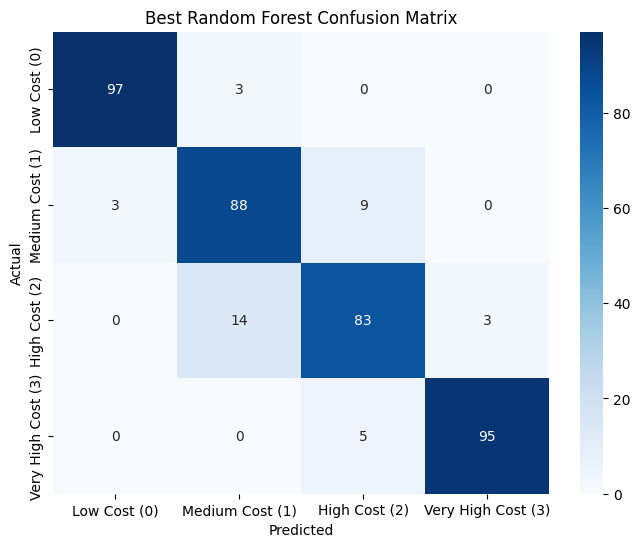


Classification Report for Best Model:
                    precision    recall  f1-score   support

      Low Cost (0)       0.97      0.97      0.97       100
   Medium Cost (1)       0.84      0.88      0.86       100
     High Cost (2)       0.86      0.83      0.84       100
Very High Cost (3)       0.97      0.95      0.96       100

          accuracy                           0.91       400
         macro avg       0.91      0.91      0.91       400
      weighted avg       0.91      0.91      0.91       400



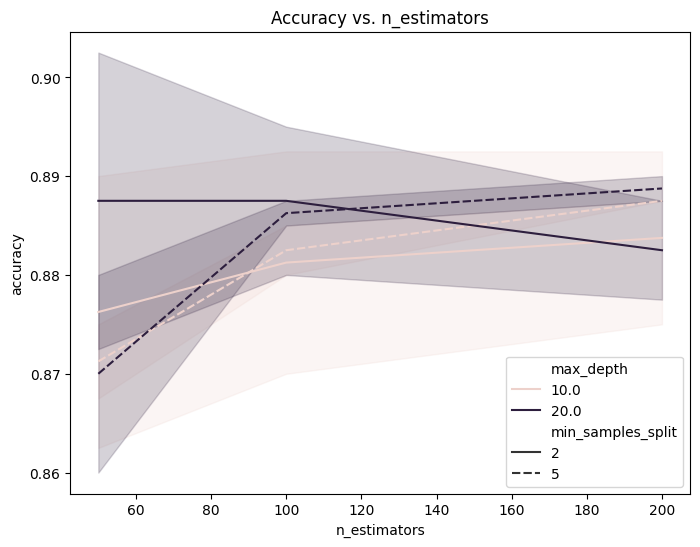

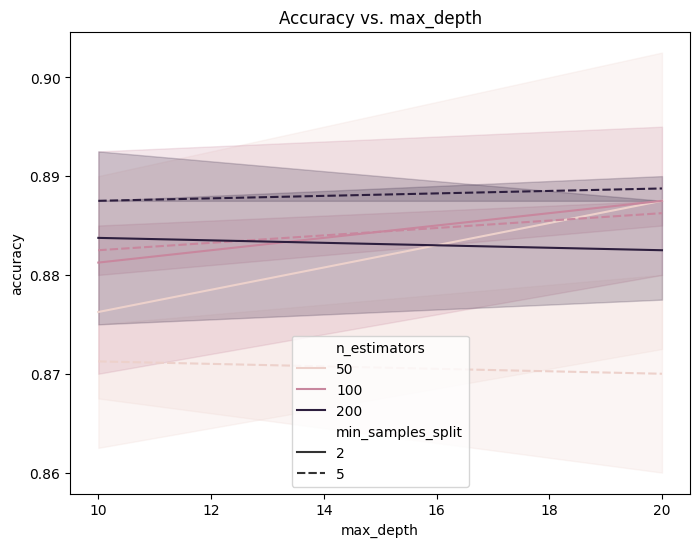

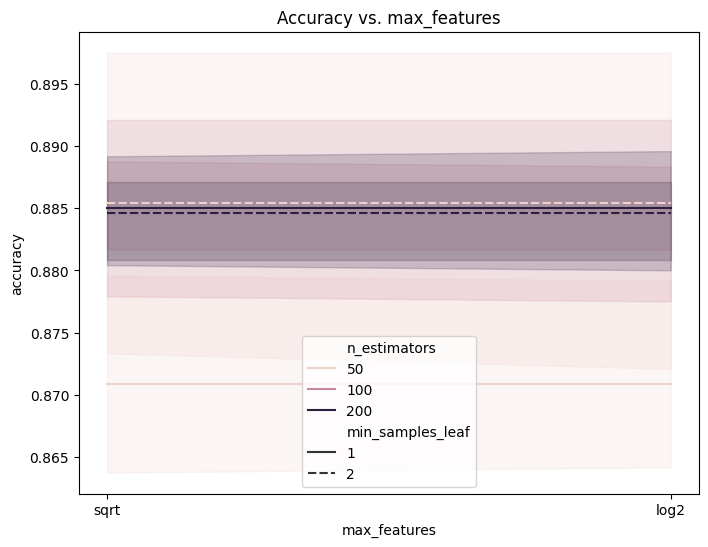

In [6]:
# Define class names
class_names = ['Low Cost (0)', 'Medium Cost (1)', 'High Cost (2)', 'Very High Cost (3)']

# Run experiments
results = run_rf_experiments(X_train, y_train, X_test, y_test, class_names)

# Visualize and save results
visualize_and_save_results(results, X_train, y_train, X_test, y_test, class_names)